In [1]:
%load_ext autoreload
%autoreload 2

# Análisis de Calidad de Datos

In [2]:
import os
import pandas as pd
from utils import pandas_api_ext
from utils import data_quality as dq
import missingno as msno
import datetime

## Entendiendo los datos

Carga de datos

In [3]:
CSV_PATH = os.path.join('..', 'primera_parte', 'data', 'processed', 'output.csv')
df = pd.read_csv(CSV_PATH)

Tamaño del dataframe

In [4]:
print(
    'filas:', df.shape[0], 
    'columnas:', df.shape[1]
)

filas: 539 columnas: 27


Columnas

In [5]:
df.columns

Index(['disc_number', 'duration_ms', 'explicit', 'track_number',
       'track_popularity', 'track_id', 'track_name',
       'audio_features.danceability', 'audio_features.energy',
       'audio_features.key', 'audio_features.loudness', 'audio_features.mode',
       'audio_features.speechiness', 'audio_features.acousticness',
       'audio_features.instrumentalness', 'audio_features.liveness',
       'audio_features.valence', 'audio_features.tempo', 'audio_features.id',
       'audio_features.time_signature', 'artist_id', 'artist_name',
       'artist_popularity', 'album_id', 'album_name', 'album_release_date',
       'album_total_tracks'],
      dtype='object')

In [6]:
df.head(3)

,disc_number,duration_ms,explicit,track_number,track_popularity,track_id,track_name,audio_features.danceability,audio_features.energy,audio_features.key,...,audio_features.tempo,audio_features.id,audio_features.time_signature,artist_id,artist_name,artist_popularity,album_id,album_name,album_release_date,album_total_tracks
0,1,212600,False,1,77,4WUepByoeqcedHoYhSNHRt,Welcome To New York (Taylor's Version),0.757,0.610,7.0,...,116.998,4WUepByoeqcedHoYhSNHRt,4.0,06HL4z0CvFAxyc27GX,Taylor Swift,120,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],2023-10-27,22
1,1,231833,False,2,78,0108kcWLnn2HlH2kedi1gn,Blank Space (Taylor's Version),0.733,0.733,0.0,...,96.057,0108kcWLnn2HlH2kedi1gn,4.0,06HL4z0CvFAxyc27GX,Taylor Swift,120,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],2023-10-27,22
2,1,231000,False,3,79,3Vpk1hfMAQme8VJ0SNRSkd,Style (Taylor's Version),0.511,0.822,11.0,...,94.868,3Vpk1hfMAQme8VJ0SNRSkd,4.0,06HL4z0CvFAxyc27GX,Taylor Swift,120,1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe],2023-10-27,22


## Completitud

Columnas con valores faltantes

In [7]:
missing_df = (
    df
    .missing
    .missing_variable_summary()
    .sort_values(by='n_missing', ascending=False)
    .reset_index(drop=True)
)

missing_df = missing_df[missing_df['n_missing']>0]
missing_df

,variable,n_missing,n_cases,pct_missing
0,album_name,62,539,11.502783
1,track_id,8,539,1.484230
2,track_name,7,539,1.298701
3,audio_features.loudness,2,539,0.371058
4,audio_features.danceability,2,539,0.371058
5,audio_features.energy,2,539,0.371058
6,audio_features.acousticness,1,539,0.185529
7,audio_features.time_signature,1,539,0.185529
8,audio_features.liveness,1,539,0.185529
9,audio_features.speechiness,1,539,0.185529


% de completitud del dataset

In [8]:
completeness = (df.missing.number_complete() / df.size)
print(f'Completitud: {completeness * 100:.2f}%')

Completitud: 99.39%


Visual gráfica de las columnas con datos faltantes

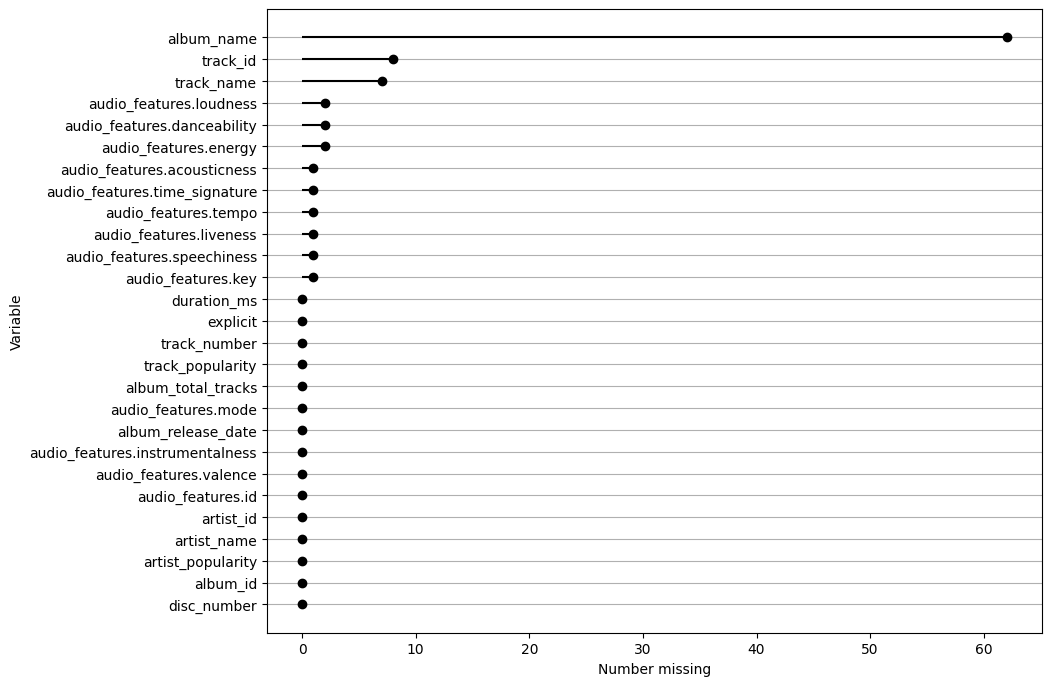

In [9]:
df.missing.missing_variable_plot()

Matriz de datos faltantes

<Axes: >

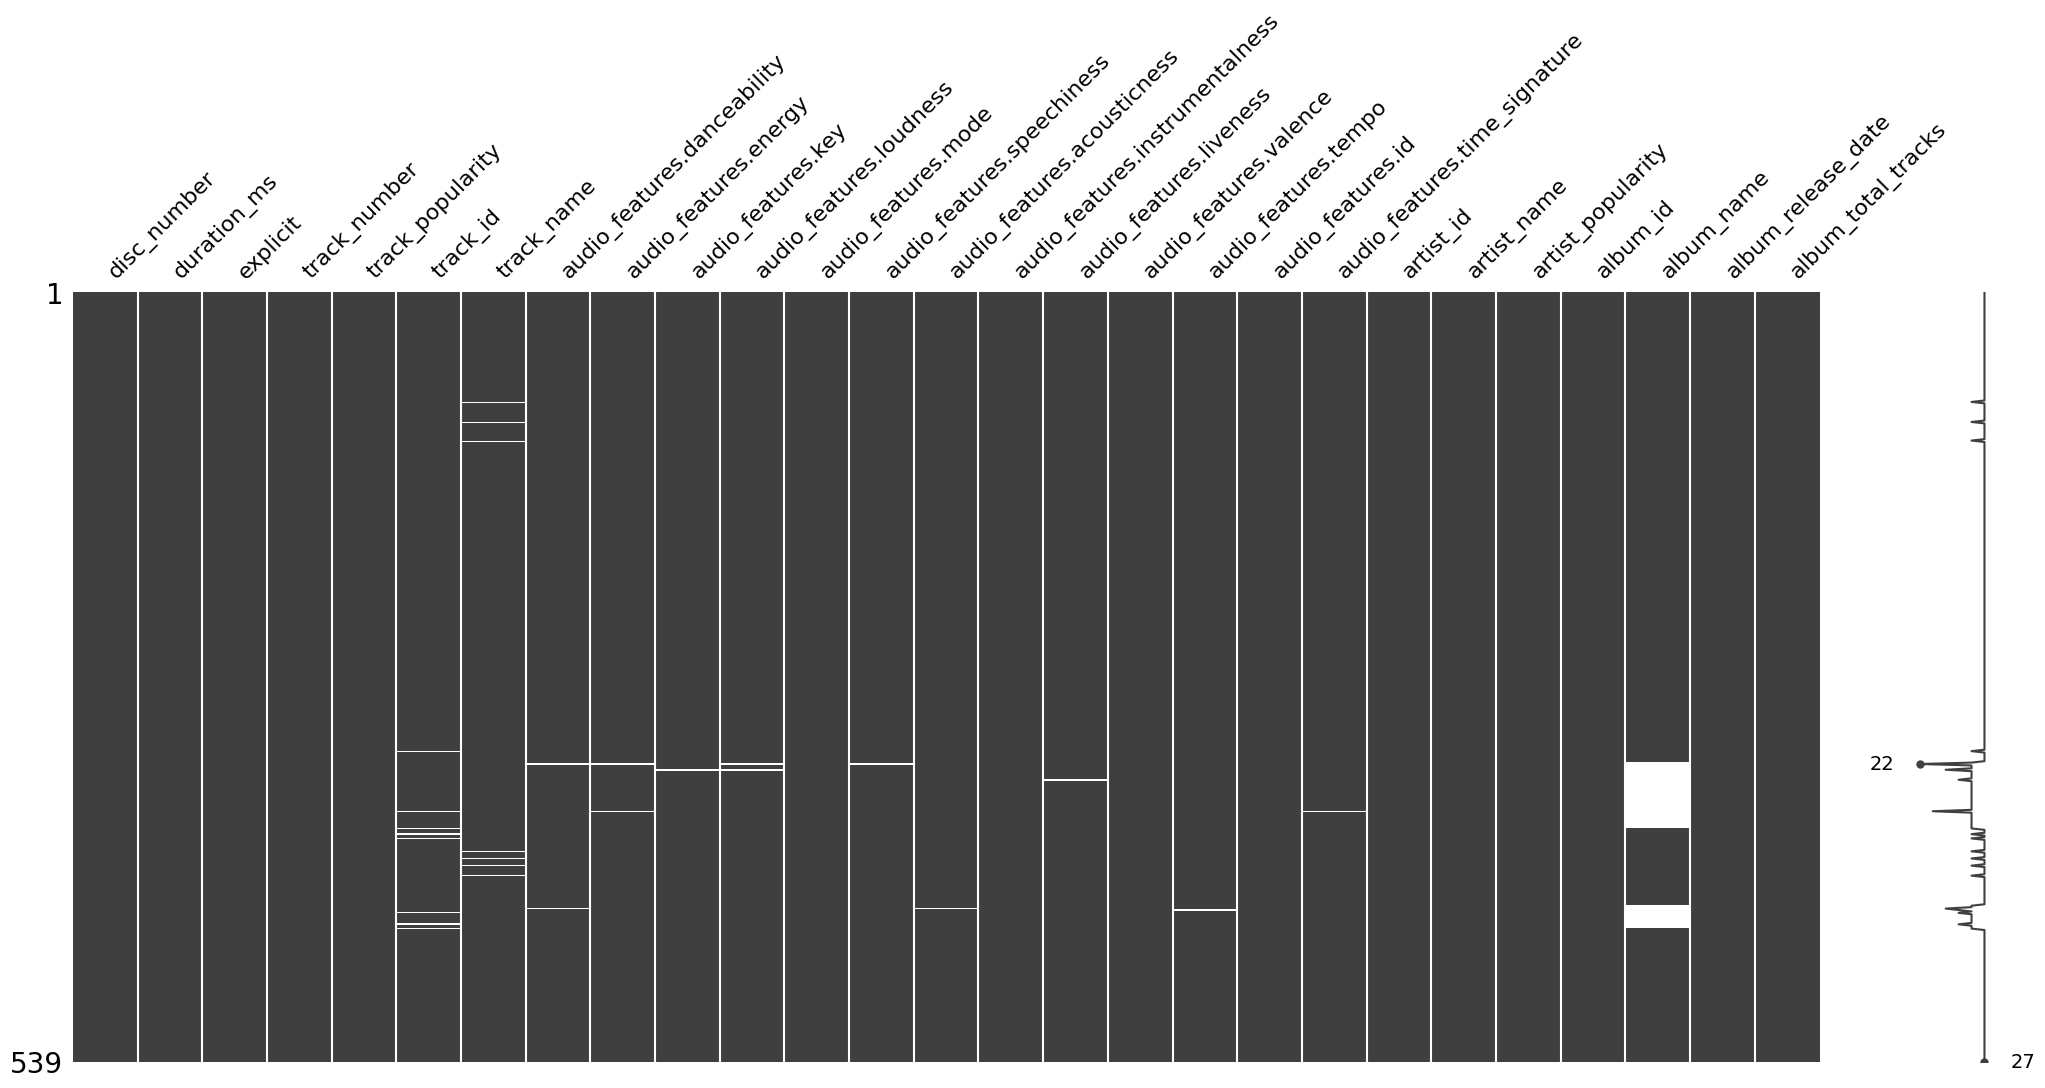

In [10]:
msno.matrix(df=df)

### Deepdive - Columnas con más valores faltantes

La columna que más valores falantes presenta es la de 'album_name'. Entraremos a analizar a qué puede deberse. Inicialmente algo curioso que se identificó es que la columna de 'album_id' *no* tiene datos faltantes, por lo que entraremos a revisar esos casos

In [11]:
missing_albums_ids = df[df['album_name'].isna()]['album_id'].unique().tolist()
missing_albums_ids

['1MPAXuTVL2Ej5x0JHiSPq8', '6fyR4wBPwLHKcRtxgd4sGh']

Son solo dos albumes a los que les faltan valores. De estos el primero se lleva el 74% de los valores faltantes y el segundo se lleva el 26% restante

In [12]:
missing_album_counts = pd.Series(index=missing_albums_ids, data=0) 
missing_album_counts.update(df['album_id'].value_counts())
missing_album_counts

1MPAXuTVL2Ej5x0JHiSPq8    46
6fyR4wBPwLHKcRtxgd4sGh    16
dtype: int64

También se valida que no exista este album_id en otro registro que sí contenga un valor en album_name y no se encontraron resultados

In [13]:
df[df['album_id'].isin(missing_albums_ids)]['album_name'].unique()

array([nan], dtype=object)

Revisando la documentación de la [API de Spotify](https://developer.spotify.com/documentation/web-api/reference/get-an-album) en la sección de 'Albums' se encuentra lo siguiente:

> The name of the album. In case of an album takedown, the value may be an empty string.

Por lo que podría tratarse de dos albumes que hayan sido borrados.

En cuanto al resto de casos con valores faltantes, estos pueden deberse a fallas durante las respuestas de la API o simplemente a data faltante como el caso anterior. Sin embargo no representan un porcentaje singficativo sobre el total de la data. Por tanto y asumiendo que el porcentaje de completitud del dataframe va acorde a los lineamientos de la compañía, podemos dar por concluida esta sección afirmando que el dataframe cumple con ella.

## Unicidad

En esta sección vamos a revisar:
- Que no existan filas repetidas.
- Que no existan track_ids (nuestro nivel de granularidad más bajo) repetidos.
- Que no existan llaves primarias (ej: artist_id, album_id) que referencien datos diferentes.
- % de unicidad

### Filas repetidas
En todo el dataframe hay 36 filas repetidas

In [14]:
len(df[df.duplicated(keep=False)])

36

In [79]:
df[df.duplicated(keep=False)][['track_id', 'track_name', 'album_id', 'album_name', 'audio_features.id']].sort_values('track_id').head(4)

,track_id,track_name,album_id,album_name,audio_features.id
303,12M5uqx0ZuwkpLp5rJim1a,Cornelia Street,1NAmidJlEaVgA3MpcPFYGq,Lover,12M5uqx0ZuwkpLp5rJim1a
285,12M5uqx0ZuwkpLp5rJim1a,Cornelia Street,1NAmidJlEaVgA3MpcPFYGq,Lover,12M5uqx0ZuwkpLp5rJim1a
305,1LLXZFeAHK9R4xUramtUKw,London Boy,1NAmidJlEaVgA3MpcPFYGq,Lover,1LLXZFeAHK9R4xUramtUKw
287,1LLXZFeAHK9R4xUramtUKw,London Boy,1NAmidJlEaVgA3MpcPFYGq,Lover,1LLXZFeAHK9R4xUramtUKw


### track_ids Repetidos

Existen 38 track_ids repetidos, provenientes de una duplicación de 19 track_ids que serían los originales

In [84]:
df[df.duplicated(subset=['audio_features.id'], keep=False)][['track_id', 'track_name', 'album_id', 'album_name', 'audio_features.id']].sort_values('audio_features.id').head(8)

,track_id,track_name,album_id,album_name,audio_features.id
303,12M5uqx0ZuwkpLp5rJim1a,Cornelia Street,1NAmidJlEaVgA3MpcPFYGq,Lover,12M5uqx0ZuwkpLp5rJim1a
285,12M5uqx0ZuwkpLp5rJim1a,Cornelia Street,1NAmidJlEaVgA3MpcPFYGq,Lover,12M5uqx0ZuwkpLp5rJim1a
278,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,1NAmidJlEaVgA3MpcPFYGq,Lover,1BxfuPKGuaTgP7aM0Bbdwr
296,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,1NAmidJlEaVgA3MpcPFYGq,Lover,1BxfuPKGuaTgP7aM0Bbdwr
305,1LLXZFeAHK9R4xUramtUKw,London Boy,1NAmidJlEaVgA3MpcPFYGq,Lover,1LLXZFeAHK9R4xUramtUKw
287,1LLXZFeAHK9R4xUramtUKw,London Boy,1NAmidJlEaVgA3MpcPFYGq,Lover,1LLXZFeAHK9R4xUramtUKw
311,1SmiQ65iSAbPto6gPFlBYm,It’s Nice To Have A Friend,1NAmidJlEaVgA3MpcPFYGq,Lover,1SmiQ65iSAbPto6gPFlBYm
293,1SmiQ65iSAbPto6gPFlBYm,It’s Nice To Have A Friend,1NAmidJlEaVgA3MpcPFYGq,Lover,1SmiQ65iSAbPto6gPFlBYm


In [15]:
duplicate_tracks = dq.check_duplicates(df, 'track_id')
duplicate_tracks['real_duplicated'] = duplicate_tracks['duplicated'] - 1
print(f'Existen {duplicate_tracks["real_duplicated"].sum()} track_ids que fueron duplicados')
duplicate_tracks

Existen 19 track_ids que fueron duplicados


,track_id,duplicated,real_duplicated
0,12M5uqx0ZuwkpLp5rJim1a,2,1
1,2dgFqt3w9xIQRjhPtwNk3D,2,1
2,5hQSXkFgbxjZo9uCwd11so,2,1
3,4y5bvROuBDPr5fuwXbIBZR,2,1
4,4AYtqFyFbX0Xkc2wtcygTr,2,1
5,43rA71bccXFGD4C8GOpIlN,2,1
6,3xYJScVfxByb61dYHTwiby,2,1
7,3pHkh7d0lzM2AldUtz2x37,2,1
8,3RauEVgRgj1IuWdJ9fDs70,2,1
9,2YWtcWi3a83pdEg3Gif4Pd,2,1


Ahora bien, si consideramos que cada track tiene un audio_features.id único, podríamos hacer el conteo de duplicados con este id para tener en consideración aquellos tracks_ids vacíos

In [76]:
len(df) - 20

519

In [75]:
duplicate_tracks = dq.check_duplicates(df, 'audio_features.id')
duplicate_tracks['real_duplicated'] = duplicate_tracks['duplicated'] - 1
print(f'Existen {duplicate_tracks["real_duplicated"].sum()} audio_features.id que fueron duplicados')
duplicate_tracks

Existen 20 audio_features.id que fueron duplicados


,audio_features.id,duplicated,real_duplicated
0,12M5uqx0ZuwkpLp5rJim1a,2,1
1,1BxfuPKGuaTgP7aM0Bbdwr,2,1
2,5hQSXkFgbxjZo9uCwd11so,2,1
3,4y5bvROuBDPr5fuwXbIBZR,2,1
4,4AYtqFyFbX0Xkc2wtcygTr,2,1
5,43rA71bccXFGD4C8GOpIlN,2,1
6,3xYJScVfxByb61dYHTwiby,2,1
7,3pHkh7d0lzM2AldUtz2x37,2,1
8,3RauEVgRgj1IuWdJ9fDs70,2,1
9,2dgFqt3w9xIQRjhPtwNk3D,2,1


### Consistencia llaves primarias

In [16]:
key_pairs_compare = [
    ('album_id', 'album_name'), 
    ('album_name', 'album_id'),
    ('artist_id', 'artist_name'),
    ('artist_name', 'artist_id'),
    ('track_id', 'track_name'),
    ('track_name', 'track_id')
]

In [59]:
df_unique = df.drop_duplicates().drop_duplicates(subset=['audio_features.id', 'album_id']).copy()
duplicates = dq.validate_key_to_value_consistency(df_unique, key_pairs_compare)

No se encontraron inconsistencias en 'album_id' respecto a 'album_name':
No se encontraron inconsistencias en 'album_name' respecto a 'album_id':
No se encontraron inconsistencias en 'artist_id' respecto a 'artist_name':
No se encontraron inconsistencias en 'artist_name' respecto a 'artist_id':
No se encontraron inconsistencias en 'track_id' respecto a 'track_name':
Inconsistencias encontradas en 'track_name' respecto a 'track_id':


Se encontraron 306 tracks que tienen nombres repetidos entre sí. De esos 306 solo 128 son los nombres únicos. En otras palabras: hay 128 track_names que están repetidos al menos una vez

In [85]:
print(duplicates[['track_name']].nunique())
duplicates[['track_id', 'track_name', 'album_id', 'album_name']].sort_values('track_name').reset_index(drop=True)

track_name    128
dtype: int64


,track_id,track_name,album_id,album_name
0,0CD7DzeCsuPJygddqlUVYa,"""Slut!"" (Taylor's Version) (From The Vault)",1o59UpKw81iHR0HPiSkJR0,1989 (Taylor's Version) [Deluxe]
1,71BqAINEnezjQfxE4VuJfq,"""Slut!"" (Taylor's Version) (From The Vault)",64LU4c1nfjz1t4VnGhagcg,1989 (Taylor's Version)
2,3WC5CVAahvn98hiseoIvbw,22,1KVKqWeRuXsJDLTW0VuD29,Red (Deluxe Edition)
3,2P5gfMtCcKP0CkmgqFMyPg,22,1MPAXuTVL2Ej5x0JHiSPq8,NaN
4,2RSYYe7LhKFxIi50T5XtUo,A Place in this World,1MPAXuTVL2Ej5x0JHiSPq8,NaN
...,...,...,...,...
301,0PurA4JVJ8YQgSVopY8fn6,tolerate it,2Xoteh7uEpea4TohMxjtaq,evermore
302,0lx2cLdOt3piJbcaXIV74f,willow,2Xoteh7uEpea4TohMxjtaq,evermore
303,2gVhfX2Gy1T9kDuS9azrF7,willow,6AORtDjduMM3bupSWzbTSG,evermore (deluxe version)
304,6sQckd3Z8NPxVVKUnavY1F,‘tis the damn season,6AORtDjduMM3bupSWzbTSG,evermore (deluxe version)


### % de Unicidad

En este caso lo veremos este % basados en la unicidad del track_id

In [19]:
unique_tracks = df['track_id'].nunique()
total_tracks = len(df)
uniqueness = unique_tracks / total_tracks
print(f'La unicidad del dataframe es de {uniqueness*100:.2f}%')

La unicidad del dataframe es de 94.99%


Si se evalua basado en el track name

In [20]:
unique_tracks = df['track_name'].nunique()
total_tracks = len(df)
uniqueness = unique_tracks / total_tracks
print(f'La unicidad del dataframe es de {uniqueness*100:.2f}%')

La unicidad del dataframe es de 61.41%


Si se evalua basado en audio_features.id

In [61]:
unique_tracks = df['audio_features.id'].nunique()
total_tracks = len(df)
uniqueness = unique_tracks / total_tracks
print(f'La unicidad del dataframe es de {uniqueness*100:.2f}%')

La unicidad del dataframe es de 96.29%


## Validez y Precisión

Aquí validaremos que cada columna contenga tipos de datos consistentes. Los tipos de datos que validaremos son:
- Numericos (int y float)
  - positivo
  - negativo
- Strings
- Dates
- Booleans

También se tendran en cuenta otras validaciones lógicas del dataset

### Tipos de datos

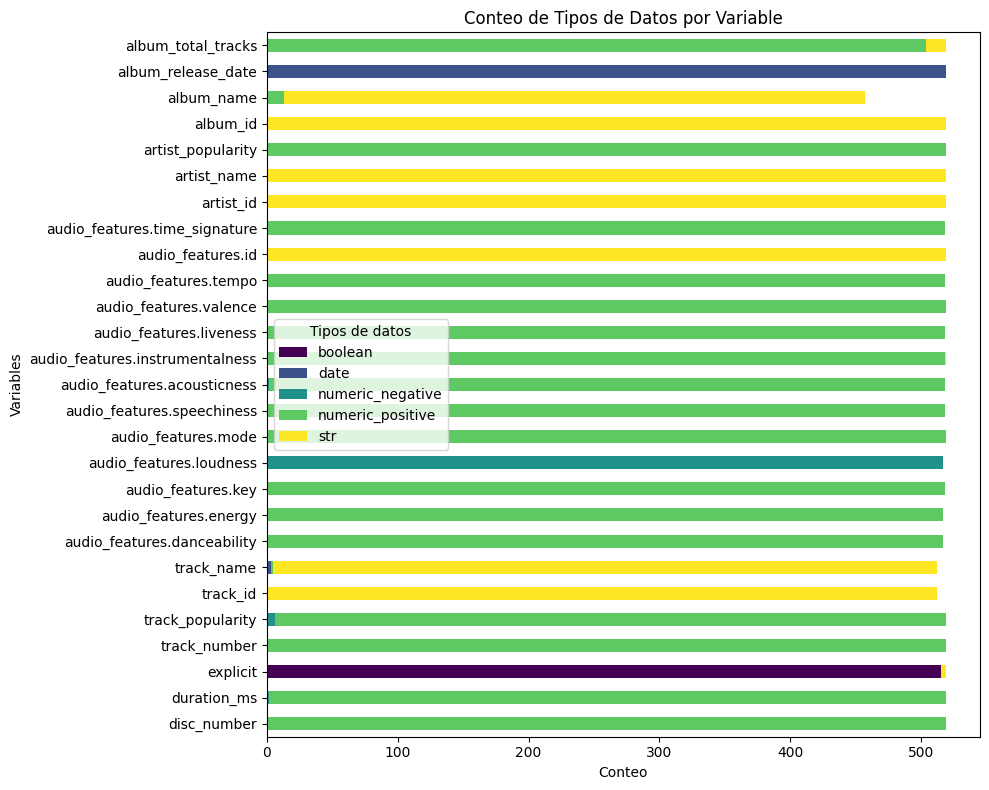

In [62]:
validity_matrix = dq.infer_and_validate_data_types(df_unique)
dq.graph_data_types(validity_matrix.drop(['NaN'], axis=1))

### Validaciones (precisión)

#### No se cumple con el tipo de Dato

En la gráfica anterior resalta que en la columna 'album_total_tracks' la regla general es que los datos deberían ser númericos, sin embargo hay 15 casos donde esto no sucede y se debe a que en lugar de poner el número 13 se puso Thirteen.

In [63]:
df_not_valid = df_unique.copy()
df_not_valid['album_total_tracks_type'] = df_not_valid['album_total_tracks'].apply(dq.infer_type)
df_not_valid = df_not_valid[df_not_valid['album_total_tracks_type'] == 'str'].groupby('album_total_tracks').size()
df_not_valid

album_total_tracks
Thirteen    15
dtype: int64

Adicionalmente también se identifica que en la columna explicit deberían haber en su mayoría valores booleanos, sin embargo hay 4 casos donde el valor está puesto como 'Si' o 'No'

In [64]:
df_not_valid = df_unique.copy()
df_not_valid['explicit_type'] = df_not_valid['explicit'].apply(dq.infer_type)
df_not_valid = df_not_valid[df_not_valid['explicit_type'] == 'str'].groupby('explicit').size()
df_not_valid

explicit
No    3
Si    1
dtype: int64

#### No se cumple que todos los valores sean positivos

Se identifican tres columnas donde hay valores negativos que no tienen mucho sentido y se procede a validarlas:
- 'duration_ms'
- 'track_popularity'
- 'audio_features.acousticness'

'audio_features.loudness' es otra variable con valores negativos, sin embargo la documentación nos dice que este valor debe ir entre -60 y 0.

In [65]:
validity_matrix[validity_matrix['numeric_negative']>0]

,NaN,boolean,date,numeric_negative,numeric_positive,str
duration_ms,0.0,0.0,0.0,2.0,517.0,0.0
track_popularity,0.0,0.0,0.0,6.0,513.0,0.0
audio_features.loudness,2.0,0.0,0.0,517.0,0.0,0.0
audio_features.acousticness,1.0,0.0,0.0,2.0,516.0,0.0


##### duration_ms
En este caso se encontró que hay dos tracks que tienen una duración negativa, lo cual no tiene mucho sentido si hablamos de una medida de tiempo

In [66]:
df_unique[df_unique['duration_ms']<0][['track_id', 'track_name', 'duration_ms']]

,track_id,track_name,duration_ms
392,4eTXfpHxhxVofrBUjAhPMg,I Wish You Would - Voice Memo,-107133
408,7gJtmLyPTwKzhGzMBXtuXH,NaN,-223093


##### track_popularity

In [67]:
df_unique[df_unique['track_popularity']<0][['track_id', 'track_name', 'track_popularity']]

,track_id,track_name,track_popularity
75,45R112Jz5hQeKgITXgSXzs,Karma,-69
89,4g2c7NoTWAOSYDy44l9nub,Lavender Haze,-70
109,5jQI2r1RdgtuT8S3iG8zFC,Lavender Haze,-85
111,0V3wPSX9ygBnCm8psDIegu,Anti-Hero,-92
115,0heeNYlwOGuUSe7TgUD27B,Question...?,-75
128,2r9CbjYgFhtAmcFv1cSquB,I Almost Do (Taylor's Version),-71


##### audio_features.acousticness

In [68]:
df_unique[df_unique['audio_features.acousticness']<0][['track_id', 'track_name', 'audio_features.acousticness']]

,track_id,track_name,audio_features.acousticness
3,1OcSfkeCg9hRC2sFKB4IMJ,Out Of The Woods (Taylor's Version),-0.000537
6,3FxJDucHWdw6caWTKO5b23,I Wish You Would (Taylor's Version),-0.003540


#### Se cumplen Rangos para valores númericos?

Se establecieron los minimos y máximos de cada variable númerica **de interés** basados en la información de la API. La idea es validar qué todos los valores de cada variable cumplan con estos limites

In [69]:
# (variable_name, minimum, maximum)
NUMERIC_VALUES_W_RANGES = [
    ('track_popularity', 0, 100),
    ('artist_popularity', 0, 100),
    ('audio_features.danceability', 0, 1),
    ('audio_features.energy', 0, 1),
    ('audio_features.loudness', -60, 0),
    ('audio_features.speechiness', 0, 1),
    ('audio_features.acousticness', 0, 1),
    ('audio_features.instrumentalness', 0, 1),
    ('audio_features.liveness', 0, 1),
    ('audio_features.valence', 0, 1),
    ('audio_features.time_signature', 3, 7),
]

In [70]:
df_ranges = dq.check_ranges(df_unique, NUMERIC_VALUES_W_RANGES)
df_ranges.sum() / len(df_ranges)

track_popularity                   0.986513
artist_popularity                  0.000000
audio_features.danceability        0.996146
audio_features.energy              0.996146
audio_features.loudness            0.996146
audio_features.speechiness         0.998073
audio_features.acousticness        0.988439
audio_features.instrumentalness    0.998073
audio_features.liveness            0.998073
audio_features.valence             1.000000
audio_features.time_signature      0.998073
dtype: float64

En casi todos los casos menos en 'audio_features.acousticness' lo que no se cumple es debido a valores faltantes y no a valores fuera del rango. Aquí los casos en donde acousticness aparece incumpliendo esta regla de rangos

In [71]:
df_unique[~df_ranges['audio_features.acousticness']][['track_id', 'track_name','audio_features.acousticness']]

,track_id,track_name,audio_features.acousticness
1,0108kcWLnn2HlH2kedi1gn,Blank Space (Taylor's Version),5.000000
3,1OcSfkeCg9hRC2sFKB4IMJ,Out Of The Woods (Taylor's Version),-0.000537
6,3FxJDucHWdw6caWTKO5b23,I Wish You Would (Taylor's Version),-0.003540
431,72GIZuUXo14oyrS0si3Rgc,The Story Of Us - Live,NaN
527,1oR4MUBpyNrAViC8wPNpfm,A Place in this World,1.500000
535,7CzxXgQXurKZCyHz9ufbo1,I'm Only Me When I'm With You,2.000000


##### Datos atípicos para duration_ms

En este caso validaremos los casos atípicos en cuanto a duración de las canciones. Para esto:
- Eliminamos los valores negativos que ya descartamos en puntos anteriores
- Tranformaremos la data a minutos para leerla de manera más sencilla

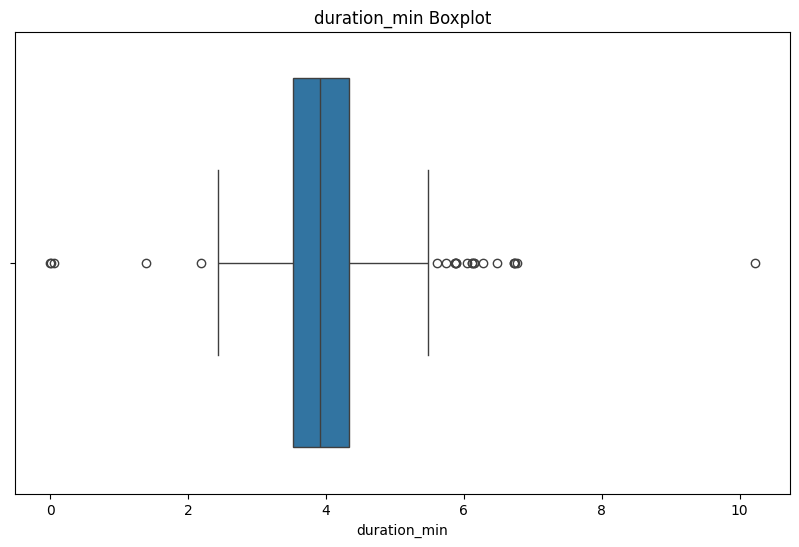

In [90]:
df_unique['duration_min'] = df_unique['duration_ms'] / 60000
outliers = dq.plot_outliers_and_return_df(df_unique[df_unique['duration_ms']>=0], 'duration_min')

In [92]:
print(f'Existen {len(outliers)} datos atípicos de duración')

Existen 23 datos atípicos de duración


In [99]:
outliers[['track_id', 'track_name', 'album_id', 'duration_ms', 'duration_min']].sort_values('duration_ms')

,track_id,track_name,album_id,duration_ms,duration_min
420,5PjfMmF06QtxTPZBZHdhoZ,Everything Has Changed,1KVKqWeRuXsJDLTW0VuD29,10,0.000167
432,7mFiEij8AXPUZB7aKLbUlQ,Mean - Live/2011,6fyR4wBPwLHKcRtxgd4sGh,1000,0.016667
472,7BFc7ffruhZ4Hecnqf5xju,Long Live,6S6JQWzUrJVcJLK4fi74Fw,3000,0.050000
440,4KB3zBArZ1rHRExilzycaV,I Want You Back - Live/2011,6fyR4wBPwLHKcRtxgd4sGh,83253,1.387550
393,4e6QU4gpfZj9xxcK856RgG,Blank Space - Voice Memo,1yGbNOtRIgdIiGHOEBaZWf,131186,2.186433
429,1aBJNc2thaKyh5THWzIqHX,Sparks Fly - Live/2011,6fyR4wBPwLHKcRtxgd4sGh,336826,5.613767
435,6505MLhnqTDDg4tjoUz2Wp,Better Than Revenge - Live/2011,6fyR4wBPwLHKcRtxgd4sGh,344573,5.742883
467,3sqrvkNC6IPTIXvvbx9Arw,Enchanted,6S6JQWzUrJVcJLK4fi74Fw,352200,5.870000
453,04S1pkp1VaIqjg8zZqknR5,Enchanted,6Ar2o9KCqcyYF9J0aQP3au,352200,5.870000
51,3sW3oSbzsfecv9XoUdGs7h,Enchanted (Taylor's Version),5AEDGbliTTfjOB8TSm1sxt,353253,5.887550


In [96]:
outliers[['track_id', 'track_name', 'album_id', 'duration_ms', 'duration_min']].sort_values('duration_ms').tail(3)

,track_id,track_name,album_id,duration_ms,duration_min
441,4DbI1rr4IQ2bc8nejy9ttd,Dear John - Live/2011,6fyR4wBPwLHKcRtxgd4sGh,404680,6.744667
47,1zU8j1x3yi9xalMF96pzKp,Dear John (Taylor's Version),5AEDGbliTTfjOB8TSm1sxt,405906,6.765100
151,5enxwA8aAbwZbf5qCHORXi,All Too Well (10 Minute Version) (Taylor's Ver...,6kZ42qRrzov54LcAk4onW9,613026,10.217100


Los datos atípicos que son mayores a 6 minutos son canciones que efectivamente sí duran esto, pero terminan siendo outliers porque se salen del tiempo usal de las canciones de la artista (puede validarse el ejemplo del track_id 5enxwA8aAbwZbf5qCHORXi donde en el mismo nombre se incluye: 10 Minute Version). 

Por el lado de los outliers por debajo de los 2.2 minutos, se puede observar que solo 3 de ellos son datos que realmente están mal. Estos son:
- 5PjfMmF06QtxTPZBZHdhoZ
- 7mFiEij8AXPUZB7aKLbUlQ
- 7BFc7ffruhZ4Hecnqf5xju

#### 'release_date' hace sentido?
- Validaremos que las fechas de release de las canciones sean menores o iguales al año actual, ya que esta API solo nos retorna albumnes que ya fueron lanzados
- En este caso específico también validaremos que los albumes hayan sido lanzados desde el año en que Taylor Swift está activa en la música (2004) Ref: [Wikipedia](https://es.wikipedia.org/wiki/Taylor_Swift).

En este caso hay 38 casos de tracks donde no hace sentido el año de lanzamiento

In [41]:
df_unique['album_release_date'] = pd.to_datetime(df_unique['album_release_date'])
current_year = datetime.datetime.now().year
active_year = 2004
df_dates = df_unique.copy()
df_dates = df_dates[df_dates['album_release_date'].notna()]

In [32]:
tracks_after = df_dates[(df_dates['album_release_date'].dt.year > current_year)]
tracks_before = df_dates[(df_dates['album_release_date'].dt.year < active_year)]

print(f'Cantidad de tracks donde el albúm fue "lanzado" antes del año en que Taylor Swift empezó actividades ({active_year}): {tracks_before["track_id"].count()}')
print(f'Cantidad de tracks donde el albúm fue "lanzado" posterior al año actual ({current_year}): {tracks_after["track_id"].count()}')

Cantidad de tracks donde el albúm fue "lanzado" antes del año en que Taylor Swift empezó actividades (2004): 15
Cantidad de tracks donde el albúm fue "lanzado" posterior al año actual (2023): 23


In [46]:
vars = ['track_id', 'track_name', 'album_id', 'album_name', 'album_release_date']
tracks_before[vars].head(3)

,track_id,track_name,album_id,album_name,album_release_date
524,0Jlcvv8IykzHaSmj49uNW8,the 1,5eyZZoQEFQWRHkV2xgAeBw,Taylor Swift,1989-10-24
525,4BYejINgfZF0qKDMEH2cim,Picture To Burn,5eyZZoQEFQWRHkV2xgAeBw,Taylor Swift,1989-10-24
526,2TF4UtYreqNbQ6Z9AccldU,Teardrops On My Guitar - Radio Single Remix,5eyZZoQEFQWRHkV2xgAeBw,Taylor Swift,1989-10-24


#### 'album_total_tracks' refleja el verdadero conteo de tracks del albúm?

Primero validamos que no existan albumes donde haya más de un conteo diferente de tracks. Esta prueba podemos ver que se pasa sin problemas

In [56]:
df_albums = df.drop_duplicates(subset=[ 'audio_features.id','album_id'])

original_total_tracks = (
    df_albums[df_albums['album_id'] != '5eyZZoQEFQWRHkV2xgAeBw'] # Elimino el album que tiene el error
    [['album_id', 'album_total_tracks']]
    .groupby('album_id')
    .agg(
        max=('album_total_tracks', 'max'),
        min=('album_total_tracks', 'min')
    )
)

original_total_tracks['max'] = original_total_tracks['max'].astype(int)
original_total_tracks['min']= original_total_tracks['min'].astype(int)

original_total_tracks['difference'] = original_total_tracks['max'] - original_total_tracks['min']
print('Validación pasada') if original_total_tracks['difference'].max() == 0 else print('Validación fallida')
original_total_tracks.reset_index(inplace=True)

Validación pasada


Ahora veremos que al hacer el conteo manual de tracks por album nos de igual que el conteo existente

In [57]:
manual_total_tracks = (
    df_albums[df_albums['album_id'] != '5eyZZoQEFQWRHkV2xgAeBw'] # Elimino el album que tiene el error
    [['album_id', 'track_id']]
    .groupby('album_id')
    .agg(
        manual_count=('track_id', 'size')
    )
)

manual_total_tracks.reset_index(inplace=True)

combined_df = manual_total_tracks.merge(
    original_total_tracks[['album_id', 'max']],
    on='album_id',
    how='left'
)
combined_df.rename(columns={'max': 'original_count'}, inplace=True)

combined_df['difference'] = combined_df['manual_count'] - combined_df['original_count']
print('Validación pasada') if combined_df['difference'].max() == 0 else print('Validación fallida')
combined_df[combined_df['difference'] != 0]

Validación fallida


,album_id,manual_count,original_count,difference
6,1fnJ7k0bllNfL1kVdNVW1A,23,24,-1
11,2Xoteh7uEpea4TohMxjtaq,15,10,5
24,6kZ42qRrzov54LcAk4onW9,30,34,-4


En este caso encontramos que hay 4 albumes que tienen un conteo diferente al que se está mostrando.

In [58]:
precision_total_tracks = 1 - (combined_df[combined_df['difference'] != 0]['album_id'].count() \
/ combined_df['album_id'].count())

print(f'La precisión de albumes con un conteo acertado es de {precision_total_tracks*100:.2f}%')

La precisión de albumes con un conteo acertado es de 88.00%
